In [1]:
# Pacotes que serão utilizados em todo o script
import pandas as pd
import mlflow
import statsmodels.api as sm
import json
import requests
import matplotlib.pyplot as plt

In [3]:
# Coletando o caminho do dataset
caminho = "/home/cairo/code/usp_ds_bigdata/bd_deployment/datasets/tempodist.csv"

# Carregando o dataset
df_tempodist = pd.read_csv(caminho)

In [5]:
df_tempodist

tempo  distancia
0     15          8
1     20          6
2     20         15
3     40         20
4     50         25
5     25         11
6     10          5
7     55         32
8     35         28
9     30         20

In [6]:
df_tempodist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   tempo      10 non-null     int64
 1   distancia  10 non-null     int64
dtypes: int64(2)
memory usage: 288.0 bytes


In [7]:
df_tempodist.describe()

tempo  distancia
count  10.00000  10.000000
mean   30.00000  17.000000
std    14.90712   9.510228
min    10.00000   5.000000
25%    20.00000   8.750000
50%    27.50000  17.500000
75%    38.75000  23.750000
max    55.00000  32.000000

### Treinando um modelo localmente

In [8]:
modelo_nulo_local = sm.OLS.from_formula(
    formula='tempo ~ distancia', 
    data=df_tempodist
).fit()

In [9]:
modelo_nulo_local.summary()

/home/cairo/.local/share/virtualenvs/usp_ds_bigdata-ev0I9uRp/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempo   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     36.30
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           0.000314
Time:                        19:24:37   Log-Likelihood:                -32.123
No. Observations:                  10   AIC:                             68.25
Df Residuals:                       8   BIC:                             68.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8784      4.532      1.297      0.231      -4.573      16.330
distancia      1.4189      0.235      6.025      0.000       0.876       1.962
==============================================================================
Omnibus:                        1.016   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.602   Jarque-Bera (JB):                0.694
Skew:                          -0.262   Prob(JB):                        0.707
Kurtosis:                       1.820   Cond. No.                         41.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Inicializando o MLFlow

In [10]:
# Apontar a instância do mlflow para o servidor que está rodando a aplicação
mlflow.set_tracking_uri('http://127.0.0.1:5000')

In [11]:
# Criando o nosso primeiro experimento
mlflow.set_experiment(experiment_name='Regressão Linear Simples - tempodist')

2024/10/04 19:42:13 INFO mlflow.tracking.fluent: Experiment with name 'Regressão Linear Simples - tempodist' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/463644338875980228', creation_time=1728081733754, experiment_id='463644338875980228', last_update_time=1728081733754, lifecycle_stage='active', name='Regressão Linear Simples - tempodist', tags={}>

### Definição dos Inputs do Modelo

In [12]:
# Coleta dos metadados do dataset para o padrão do mlflow
dataset = mlflow.data.from_pandas(df_tempodist)
# Fórmula que serão utilizada no modelo
formula = 'tempo ~ 1'

/home/cairo/.local/share/virtualenvs/usp_ds_bigdata-ev0I9uRp/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/cairo/.local/share/virtualenvs/usp_ds_bigdata-ev0I9uRp/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 2

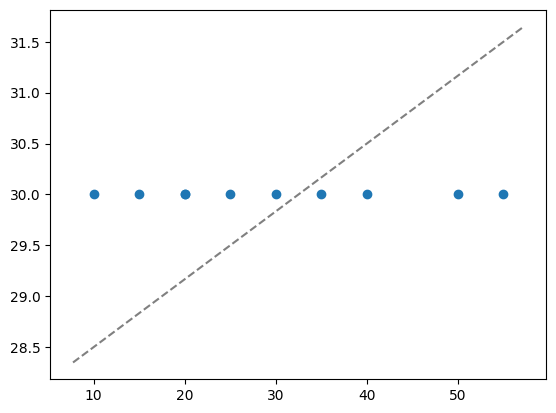

In [13]:
# Criando o nosso primeiro experimento no mlflow
with mlflow.start_run(run_name="Modelo Nulo"):

    # ==================== INPUTS =============================================

    # Coleta dos metadados do dataset. O contexto pode ser utilizado para adi-
    # cionar mais uma informação de contexto do dataset, por exemplo: se ele é
    # um dataset de treino ou teste
    mlflow.log_input(dataset, context="training")

    # Parâmetros de entrada para serem coletados
    mlflow.log_param("Fórmula", formula)

    # ==================== MODELAGEM ==========================================

    # Treinamento do modelo
    modelo_nulo = sm.OLS.from_formula(formula=formula, data=df_tempodist).fit()

    # ==================== OUTPUTS ============================================

    # Registrando as métricas do modelo
    mlflow.log_metric("Estatística F", modelo_nulo.fvalue)
    mlflow.log_metric("F p-value", modelo_nulo.f_pvalue)
    mlflow.log_metric("R2", modelo_nulo.rsquared)

    # Coletando artefatos do modelo

    # Gráfico do comparativo dos dados observados versus fittedvalues
    fig, ax = plt.subplots()
    ax.scatter(df_tempodist["tempo"], modelo_nulo.fittedvalues)
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", color="gray")

    # Registro do gráfico como um artefato do experimento
    mlflow.log_figure(
        fig, "observado_vs_fitted.png"
    )  # importante definir a extensão

    # Obtendo o sumário do modelo em formato de texto
    modelo_nulo_summary_texto = modelo_nulo.summary().as_text()

    # Registro do sumário como um artefato do experimento
    mlflow.log_text(
        modelo_nulo_summary_texto, "summary.txt"
    )  # importante definir a extensão do arquivo

    # Carregamento do modelo no experimento
    mlflow.statsmodels.log_model(modelo_nulo, "modelo-nulo")

### Utilizando Modelos em Produção

In [14]:
modelo_nulo_carregado = mlflow.statsmodels.load_model(
    'models:/tempo-distancia/staging'
)

/home/cairo/.local/share/virtualenvs/usp_ds_bigdata-ev0I9uRp/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:31: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


In [15]:
# Verificando o R2
modelo_nulo_carregado.rsquared

np.float64(0.0)

In [16]:
# Verificando os fittedvalues
modelo_nulo_carregado.fittedvalues

0    30.0
1    30.0
2    30.0
3    30.0
4    30.0
5    30.0
6    30.0
7    30.0
8    30.0
9    30.0
dtype: float64

## Modelo final

In [17]:
# Coleta dos metadados do dataset para o padrão do mlflow
dataset = mlflow.data.from_pandas(df_tempodist)
# Fórmula que serão utilizada no modelo
formula = "tempo ~ distancia"

/home/cairo/.local/share/virtualenvs/usp_ds_bigdata-ev0I9uRp/lib/python3.10/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/cairo/.local/share/virtualenvs/usp_ds_bigdata-ev0I9uRp/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 2

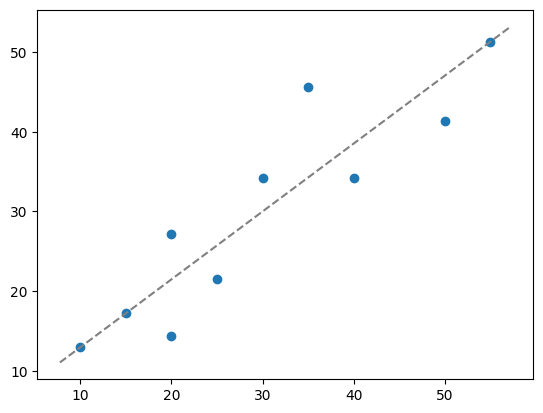

In [18]:
# Criando o nosso primeiro experimento no mlflow
with mlflow.start_run(run_name="Modelo Final"):

    # =============================== INPUTS ==================================

    # Coleta dos metadados do dataset. O contexto pode ser utilizado para adi-
    # cionar mais uma informação de contexto do dataset, por exemplo: se ele é
    # um dataset de treino ou teste
    mlflow.log_input(dataset, context="training")

    # Parâmetros de entrada para serem coletados
    mlflow.log_param("Fórmula", formula)

    # ============================= MODELAGEM =================================

    # Treinamento do modelo
    modelo_final = sm.OLS.from_formula(
        formula=formula, data=df_tempodist
    ).fit()

    # ============================= OUTPUTS ===================================

    # Registrando as métricas do modelo
    mlflow.log_metric("Estatística F", modelo_final.fvalue)
    mlflow.log_metric("F p-value", modelo_final.f_pvalue)
    mlflow.log_metric("R2", modelo_final.rsquared)

    # Coletando artefatos do modelo

    # Gráfico do comparativo dos dados observados versus fittedvalues
    fig, ax = plt.subplots()
    ax.scatter(df_tempodist["tempo"], modelo_final.fittedvalues)
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", color="gray")

    # Registro do gráfico como um artefato do experimento
    mlflow.log_figure(
        fig, "observado_vs_fitted.png"
    )  # importante definir a extensão

    # Obtendo o sumário do modelo em formato de texto
    modelo_final_summary_texto = modelo_final.summary().as_text()

    # Registro do sumário como um artefato do experimento
    mlflow.log_text(
        modelo_nulo_summary_texto, "summary.txt"
    )  # importante definir a extensão do arquivo

    # Carregamento do modelo no experimento
    mlflow.statsmodels.log_model(modelo_final, "modelo-final")

- Registrando uma nova versão do modelo tempo-dist
- Agora o modelo tempo-dist terá duas versões, o modelo nulo na versão 1 e o modelo final na versão 2.
- Após promover o modelo final para a fase de 'staging', o modelo nulo automaticamente o modelo anterior será e o novo modelo ficará registrado no estágio de 'staging' (adaptação)


In [19]:
# Carregando novamente o modelo tempo-dist na fase 'staging'
modelo_fase_staging = mlflow.statsmodels.load_model(
    "models:/tempo-distancia/staging"
)

/home/cairo/.local/share/virtualenvs/usp_ds_bigdata-ev0I9uRp/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:31: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


In [20]:
# Verificando o R2
modelo_fase_staging.rsquared

np.float64(0.8194256756756757)

In [21]:
# Verificando os fittedvalues
modelo_fase_staging.fittedvalues

0    17.229730
1    14.391892
2    27.162162
3    34.256757
4    41.351351
5    21.486486
6    12.972973
7    51.283784
8    45.608108
9    34.256757
dtype: float64

In [23]:
# Realizando um predict
predict_novo_modelo_staging = modelo_fase_staging.predict(
    pd.DataFrame({'distancia': [20]})
)
print(predict_novo_modelo_staging)


0    34.256757
dtype: float64


### Gestão Ciclo de Vida dos Modelos

- Ciclo esperado: Adatação -> Produção -> Arquivamento

- Promovendo o modelo final de fase de adaptação para a fase de produção
- Agora a versão 2 do modelo (modelo final) está em produção


In [24]:
# Carregando modelo tempo-dist em produção (production)
modelo_em_producao = mlflow.statsmodels.load_model(
    "models:/tempo-distancia/production"
)

/home/cairo/.local/share/virtualenvs/usp_ds_bigdata-ev0I9uRp/lib/python3.10/site-packages/mlflow/store/artifact/utils/models.py:31: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


### Consumindo APIs
- Alguns métodos HTTP bastante utilizados em requisições de APIs:
    - GET: recupera dados do servidor
    - POST: envia dados ao servidor para processamento

In [25]:
fatos_cachorros = requests.get(
    "https://dogapi.dog/api/v2/facts",
    headers={"Content-Type": "application/json"}
)

Documentação desta API aqui https://dogapi.dog/docs/api-v2

In [26]:
# Coletando a resposta da requisição em formaton JSON
fatos_cachorros = fatos_cachorros.json()

In [27]:
# Acessando os campos e valores da resposta da API
print(fatos_cachorros["data"][0]["attributes"]["body"])

About 12 percent of the air that a dog breathes goes into a special area in the back of the nose that is dedicated to smelling.


### SERVINDO MODELOS EM PRODUÇÃO USANDO A API DO MLFLOW 

- Acesse um novo terminal e ative o ambiente virtual que foi criado. Não feche o terminal que está rodando o Mlflow.
- Verifique o Passo 2 do "Instruções Aula - Big Data e Deployment de Modelos" para mais dúvidas.

Adicione a variável de ambiente para o rastreamento de onde está o Mlflow
- Linux/macOS: `EXPORT MLFLOW_TRACKING_URI=http://localhost:5000`
- Windows: `SET MLFLOW_TRACKING_URI=http://localhost:5000`

Sirva o modelo tempo-distancia em fase de produção para ser acessado na porta 5200 via API do Mlflow
`mlflow models serve -m models:/tempo-distancia/production -p 5200 --no-conda`


In [28]:
# Criando um dataframe para realizar um predict no nosso modelo em produção via
# API do Mlflow
df_novos_dados = pd.DataFrame({'distancia': [20]})

In [29]:
# Transformando os dados para o formato requisitação pela documentação da API
#  do mlflow
dados_transformados = json.dumps(
    {"dataframe_records": df_novos_dados.to_dict(orient="records")}
)

In [30]:
# Realizando a requisição ao modelo via API do Mlflow e coletando a resposta
response = requests.post(
    url="http://127.0.0.1:5200/invocations",
    data = dados_transformados,
    headers = {"Content-Type": "application/json"}
)

In [31]:
# Verificando o retorno
response.text

'{"predictions": [{"0": 34.25675675675676}]}'

In [33]:
# Verificando o retorno, agora no formato JSON
predict = response.json()
print(predict['predictions'][0]['0'])

34.25675675675676
